In [29]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from scipy.stats.mstats import rankdata
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from label_ranking import *
from rank_aggregation import *
from dataloader import *
from sklearn.metrics import make_scorer

In [5]:
ullmann_dataset = UllmannDataset(False, 4)

X_train_desc = ullmann_dataset.X_desc
y_train_yield = ullmann_dataset.y_yield
y_train_ranking = ullmann_dataset.y_ranking

In [99]:
y_p300_yield = np.array([
    33, 5, 7, 9, 6, 21, 19, 22, 29, 21, 24, 27, 51, 53, 39, 25, 44, 54
])
y_p301_yield = np.array([
    3, 3, 6, 19, 12, 18, 18, 27, 28, 14, 10, 9, 7, 7, 0, 16, 0, 8
])

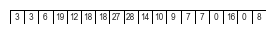

In [78]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(3.3, 0.5))
sns.heatmap(y_p301_yield.reshape(1,-1), cmap=ListedColormap(["white"]), annot=True, cbar=False, annot_kws={"fontfamily":"arial", "fontsize":6}, ax=ax, linecolor="black", linewidths=0.5, square=True)
ax.tick_params(left = False, bottom=False) 
ax.set_yticklabels([""])
ax.set_xticklabels([""]*9)

plt.savefig(f"figures/Figure6C_top.svg", dpi=300, format="svg")

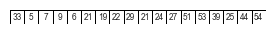

In [100]:
fig, ax = plt.subplots(figsize=(3.3, 0.5))
sns.heatmap(y_p300_yield.reshape(1,-1), cmap=ListedColormap(["white"]), annot=True, cbar=False, annot_kws={"fontfamily":"arial", "fontsize":6}, ax=ax, linecolor="black", linewidths=0.5, square=True)
ax.tick_params(left = False, bottom=False) 
ax.set_yticklabels([""])
ax.set_xticklabels([""]*9)

plt.savefig(f"figures/Figure6C_bottom.svg", dpi=300, format="svg")

In [28]:
# Getting reactants of P300 and P301
test_ArBrs = pd.read_excel("datasets/computed_data.xlsx", sheet_name="test_ArBr_DFT")
test_amines = pd.read_excel("datasets/computed_data.xlsx", sheet_name="test_amine_DFT")

X_p301_desc = np.array(
    list(test_ArBrs.iloc[0, 2:].to_numpy(dtype=np.float16)) +\
          list(test_amines.iloc[1, 2:].to_numpy(dtype=np.float16))
)
X_p301_desc.shape, X_p301_desc[:5]

((384,),
 array([-0.2913 , -0.2913 , -0.2913 , -0.2913 ,  0.04355], dtype=float16))

In [83]:
def kendall_tau(y_true, y_pred):
    kt = kendalltau(y_true, y_pred).statistic
    return kt
kt_score = make_scorer(kendall_tau, greater_is_better=True)

rpc_gcv = GridSearchCV(
    RPC(),
    param_grid={"n_estimators":[50,100,200], "max_depth":[2,5,10]},
    n_jobs = -1,
    scoring=kt_score,
    cv=5
)
rpc_gcv.fit(X_train_desc, y_train_ranking)

GridSearchCV(cv=5, estimator=RPC(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(kendall_tau))

In [84]:
y_p301_rpc_pred_rank = rpc_gcv.predict(X_p301_desc.reshape(1,-1))
y_p301_yield[np.where(y_p301_rpc_pred_rank <= 2)[1]]

array([27, 14])

In [55]:
lrrf_gcv = GridSearchCV(
    LabelRankingRandomForest(),
    param_grid={"n_estimators":[50,100,200], "max_depth":[2,5,10]},
    n_jobs = -1,
    scoring=kt_score,
    cv=5
)
lrrf_gcv.fit(X_train_desc, y_train_ranking)
y_p301_lrrf_pred_rank = lrrf_gcv.predict(X_p301_desc.reshape(1,-1))

In [82]:
y_p301_yield[np.where(y_p301_lrrf_pred_rank <= 2)[1]]

array([27,  7])

In [80]:
y_p301_lrrf_pred_rank

array([[16, 17, 18, 13, 15, 10, 14,  2,  7,  4,  3,  5,  1, 11,  6,  8,
         9, 12]])

In [85]:
y_p301_rpc_pred_rank

array([[17, 16, 18, 10, 15, 13, 11,  1,  9,  2,  4,  5,  3,  8,  6,  7,
        12, 14]])

In [97]:
np.argsort(lrrf_gcv.best_estimator_.model.feature_importances_)[-15:]

array([153,  27,  80, 102,  26, 151, 124,  66, 175, 152,  40, 101, 148,
       127,  69])

In [95]:
test_ArBrs.columns[[x+2 for x in np.argsort(lrrf_gcv.best_estimator_.model.feature_importances_)[-5:]]]

Index(['SASA_surface_area(Å²)_Boltz', '%Vbur_Br_4.0Å_min',
       'Buried_Sterimol_L_Br_C_5.0(Å)_Boltz',
       'Sterimol_L_Br_C(Å)_morfeus_low_E', '%Vbur_Br_2.0Å_min'],
      dtype='object')

In [105]:
test_amines.columns[[x-178 for x in np.argsort(lrrf_gcv.best_estimator_.model.feature_importances_)[-40:] if x > 180]]

Index(['Buried_Sterimol_B5_N_C_5.0(Å)_max', '%Vbur_N_4.0Å_max',
       'polar_iso(Debye)_low_E'],
      dtype='object')

In [101]:
np.argsort(lrrf_gcv.best_estimator_.model.feature_importances_)

array([135, 189, 270, 269, 137,  96, 240,  35,  54, 233, 231, 230, 229,
       223, 215, 198, 382, 232, 300,  49, 380, 378, 133, 131, 369,  13,
       109, 103, 108, 336,  38, 170,  55, 250, 242, 363, 341,  33,  30,
       312, 377, 302, 166, 301,  98, 122, 371, 235,  32, 295, 383, 277,
       320,  37, 357, 112, 285, 359, 132,  84, 251, 317, 256, 356, 345,
       314, 134, 305, 191, 325, 252, 338, 342, 192,  34, 361, 241, 366,
       350, 297, 199,  99, 183, 107, 111, 351, 176, 278,  19, 136, 243,
       281, 217, 324, 247, 258, 266, 263, 181, 208, 145, 259, 214, 344,
       309,  82, 330, 126, 293, 331, 332, 246, 311, 323, 244, 321, 280,
       306, 167, 329, 284, 228, 184, 319, 141, 115,  91, 219, 220, 194,
       334, 248, 352, 186,  44,  18,  16, 373, 117, 212, 163, 343, 310,
       318, 299,  15, 237, 316, 138, 236,  90, 110, 307, 185, 193, 354,
        28, 370, 149, 157, 265, 322, 327,   5,  17, 268,  56, 114, 144,
       182, 160, 195,   0, 222, 333, 276,  14, 210, 381, 227,   